In [6]:
from pyspark.sql import SparkSession

import os
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, rand, expr
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.ml.feature import StandardScaler, MinMaxScaler, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from scipy import stats

spark = SparkSession.builder.appName("Diabetic Retinopathy Detection: Data Preparation").master("spark://spark-master:7077").config("spark.executor.memory", "2g").config("spark.driver.memory", "2g").config("spark.sql.execution.arrow.pyspark.enabled", "true").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/17 15:39:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
def extract_image_features(image_path):
    # Extrait des features visuelles d'une image de rétine
        img = cv2.imread(image_path)
        if img is None:
            return None
            
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img_resized = cv2.resize(img_rgb, (256, 256))
        
        features = {}
        
        # Statistiques de couleur RGB 
        for i, channel in enumerate(['R', 'G', 'B']):
            features[f'{channel}_mean'] = np.mean(img_resized[:,:,i])
            features[f'{channel}_std'] = np.std(img_resized[:,:,i])
            features[f'{channel}_skew'] = stats.skew(img_resized[:,:,i].flatten())
        
        # features de HSV
        img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)
        for i, channel in enumerate(['H', 'S', 'V']):
            features[f'{channel}_mean'] = np.mean(img_hsv[:,:,i])
            features[f'{channel}_std'] = np.std(img_hsv[:,:,i])
            features[f'{channel}_skew'] = stats.skew(img_hsv[:,:,i].flatten())
        
        # Conversion en niveaux de gris pour texture
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
        
        # Histogramme des intensités
        hist, _ = np.histogram(img_gray.flatten(), bins=10, range=(0, 256))
        hist = hist.astype(float) / hist.sum()
        for i, val in enumerate(hist):
            features[f'intensity_hist_{i}'] = val
        
        # Contraste et luminosité
        features['contrast'] = img_gray.std()
        features['brightness'] = img_gray.mean()
        features['min_intensity'] = img_gray.min()
        features['max_intensity'] = img_gray.max()
        
        features['entropy'] = stats.entropy(hist)
        
        moments = cv2.HuMoments(cv2.moments(img_gray)).flatten()
        for i, m in enumerate(moments):
            features[f'hu_moment_{i}'] = -np.sign(m) * np.log10(np.abs(m) + 1e-10)
        
        # Détection de contours
        edges = cv2.Canny(img_gray, 100, 200)
        features['edge_density'] = np.sum(edges > 0) / edges.size
        features['edge_mean'] = np.mean(edges)
        
        return features


In [8]:
def load_dataset(spark):
    # Charge les données diabetic retinopathy et extrait les features des images

    df_labels = pd.read_csv("/home/data/train.csv")
    images_dir="/home/data/colored_images"
    class_folders = {
        0: 'No_DR',
        1: 'Mild',
        2: 'Moderate',
        3: 'Severe',
        4: 'Proliferate_DR'
    }
    
    # Extraire les features de toutes les images
    print("\nExtraction des features visuelles:")
    data_list = []
    not_found_count = 0
    
    for idx, row in df_labels.iterrows():
        id_code = str(row['id_code'])
        diagnosis = int(row['diagnosis'])
        
        # Chercher l'image dans le dossier correspondant à sa classe
        class_folder = class_folders.get(diagnosis, 'No_DR')
        image_filename = f"{id_code}.png"
        image_path = os.path.join(images_dir, class_folder, image_filename)
        
        features = extract_image_features(image_path)
        
        if features is not None:
            features['id_code'] = id_code
            features['diagnosis'] = diagnosis
            features['image_path'] = image_path
            data_list.append(features)
    
    df_pandas = pd.DataFrame(data_list)
    
    print(f"\nPremières lignes:\n{df_pandas.head()}")

    df_spark = spark.createDataFrame(df_pandas)
    
    # Créer une variable cible binaire
    df_spark = df_spark.withColumn(
        "label",
        when(col("diagnosis") >= 1, 1).otherwise(0)
    )
    
    return df_spark, df_pandas

In [9]:
def analyze_data_distribution(df_pandas):
    # Analyse et visualisation de la distribution des données
    target_col = 'diagnosis'
    
    plt.figure(figsize=(10, 6))
    df_pandas[target_col].value_counts().plot(kind='bar')
    plt.title('Distribution de la variable cible')
    plt.xlabel('Classe')
    plt.ylabel('Fréquence')

In [10]:
def normalize_features(df_spark, input_col="features_raw", output_col="features_scaled"):
    # Normalisation les features numériques
    
    from pyspark.ml.feature import VectorAssembler
    from pyspark.ml import Pipeline
    
    stages = []
    
    scaler = StandardScaler(
        inputCol=input_col,
        outputCol=output_col,
        withMean=True,
        withStd=True
    )
    
    stages.append(scaler)
    
    pipeline = Pipeline(stages=stages)
    
    scaler_model = pipeline.fit(df_spark)
    df_normalized = scaler_model.transform(df_spark)
    
    return df_normalized, scaler_model

In [12]:
def split_data(df_spark, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    
    train_val, test = df_spark.randomSplit([train_ratio + val_ratio, test_ratio], seed=42)
    
    train_ratio_adjusted = train_ratio / (train_ratio + val_ratio)
    train, val = train_val.randomSplit([train_ratio_adjusted, 1 - train_ratio_adjusted], seed=42)
    
    print(f"\nDivision des données:")
    print(f"Entraînement: {train.count()} échantillons")
    print(f"Validation: {val.count()} échantillons")
    print(f"Test: {test.count()} échantillons")
    
    return train, val, test

In [13]:
df_spark, df_pandas = load_dataset(spark)


Extraction des features visuelles:

Premières lignes:
       R_mean      R_std    R_skew     G_mean      G_std    G_skew     B_mean  \
0   80.561798  49.178122 -0.622118  43.005417  26.553892 -0.417507  16.262741   
1  128.625610  74.600872 -1.011692  58.662033  34.205513 -0.990539  14.204132   
2  117.580719  54.016907 -1.382256  51.772385  25.083139 -0.956695   9.603516   
3  133.161087  71.046022 -1.083121  71.152023  38.981911 -0.890936  32.549988   
4   38.370743  43.650732  0.791775  18.714233  22.392119  1.072005   0.766388   

       B_std     B_skew     H_mean  ...  hu_moment_2  hu_moment_3  \
0   9.174037  -0.730708  22.218536  ...     9.873550     9.880741   
1   7.728323  -0.745364  38.545914  ...     9.987213     9.988752   
2   4.206601  -0.204602  30.973358  ...     9.942324     9.924197   
3  22.038742   0.132818  12.406494  ...     9.997441     9.977856   
4   3.868855  11.252264   7.335663  ...     9.683214     9.416258   

   hu_moment_4  hu_moment_5  hu_moment_6  e

/opt/spark/python/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


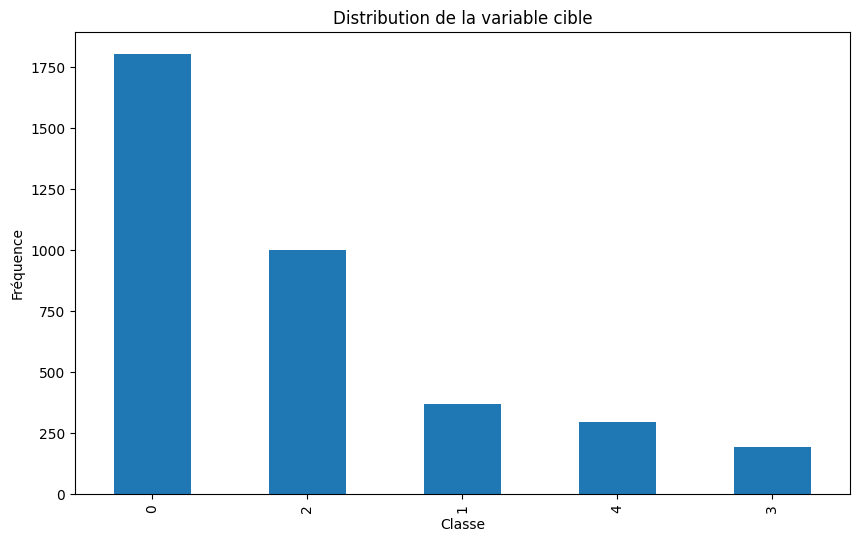

In [14]:
analyze_data_distribution(df_pandas)

In [15]:
df_spark.printSchema()

root
 |-- R_mean: double (nullable = true)
 |-- R_std: double (nullable = true)
 |-- R_skew: double (nullable = true)
 |-- G_mean: double (nullable = true)
 |-- G_std: double (nullable = true)
 |-- G_skew: double (nullable = true)
 |-- B_mean: double (nullable = true)
 |-- B_std: double (nullable = true)
 |-- B_skew: double (nullable = true)
 |-- H_mean: double (nullable = true)
 |-- H_std: double (nullable = true)
 |-- H_skew: double (nullable = true)
 |-- S_mean: double (nullable = true)
 |-- S_std: double (nullable = true)
 |-- S_skew: double (nullable = true)
 |-- V_mean: double (nullable = true)
 |-- V_std: double (nullable = true)
 |-- V_skew: double (nullable = true)
 |-- intensity_hist_0: double (nullable = true)
 |-- intensity_hist_1: double (nullable = true)
 |-- intensity_hist_2: double (nullable = true)
 |-- intensity_hist_3: double (nullable = true)
 |-- intensity_hist_4: double (nullable = true)
 |-- intensity_hist_5: double (nullable = true)
 |-- intensity_hist_6: double

In [16]:
exclude_cols = ['id_code', 'diagnosis', 'label', 'image_path']
        
# Récupérer les colonnes numériques (features extraites des images)
from pyspark.sql.types import NumericType
numeric_cols = [f.name for f in df_spark.schema.fields if isinstance(f.dataType, NumericType)]
        
feature_cols = [c for c in numeric_cols if c not in exclude_cols]
        
print(f"\nFeatures sélectionnées: {len(feature_cols)} features visuelles extraites des images")


Features sélectionnées: 42 features visuelles extraites des images


In [ ]:
# Augmentation et normalisation
df_features = prepare_features(df_spark, feature_cols)

25/12/17 15:41:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                


Distribution avant augmentation:
  Classe 1: 1857 échantillons
  Classe 0: 1805 échantillons

Distribution aprés augmentation:
  Classe 0: 1805 échantillons
  Classe 1: 1714 échantillons


In [ ]:
# Diviser les données
train, val, test = split_data(df_features)

# Sauvegarder les datasets
train.write.mode('overwrite').parquet('/home/data/processed/train')
val.write.mode('overwrite').parquet('/home/data/processed/val')
test.write.mode('overwrite').parquet('/home/data/processed/test')
        
print(f"Total de {len(feature_cols)} features visuelles extraites par image")

In [ ]:
spark.stop()